# Surrogate Construction for Genz Functions: BCS

This notebook constructs a PC surrogate for Genz functions and gives the normalized root mean square error between the surrogate and the actual function. Both the Genz function and PCE are defined on [-1,1].

In [1]:
import numpy as np
import math  
from scipy.stats import qmc
import pandas as pd

import PyUQTk.pce as uqtkpce
import PyUQTk.PyPCE.pce_tools as pce_tools
from PyUQTk.utils.func import *

PyMC is required for some of the MCMC postprocessing codes.
Will proceed without, but some convergence tests will not be available.


We define our input parameters. BCS is best for undetermined models and/or large basis sets.

In [2]:
# PC parameters
nord = 4            # Order of the final PCE basis
ndim = 4            # Number of dimensions
pc_type = "LU"      # Polynomial type
pc_alpha = 0.0      # Free parameter > -1 for Gamma-Laguerre and Beta-Jacobi PCs
pc_beta = 1.0       # Free parameter > -1 for Gamma-Laguerre and Beta-Jacobi PCs

# BCS parameters
niter = 1                                        # Number of iterations to run, must be > 0
eta = 1/np.power(10,[i for i in range(1,7)])    # Threshold for stopping the algorithm
ntry = 3                                         # Number of splits for cross-validation of the retained basis terms 
eta_folds = 20                      # Number of folds to use for eta cross-validation                          
mindex_growth =  'nonconservative'              # Method for basis growth; options are "conservative," "nonconservative," or None
regparams = None                    # Regularization weights (provide an array or value); if None, they are autopopulated
sigma = 1e-8                        # Initial noise variance; updated in BCS
trval_frac = None                   # Fraction of total data to use in each split
npccut = None                       # Maximum number of PC coefficients to retain
pcf_thr = None                      # Minimum value (by magnitude) for PC coefficients
verbose = 1                         # Flag for print statements: 0 for none, 1 for minimal statements, 2 for full output
eta_plot = True                     # Flag for plotting possible etas by RMSEs during optimization

# Model Choice 
model = 'genz_osc'   # Choices are 'genz_osc', 'genz_exp', 'genz_cont','genz_gaus','genz_cpeak', 'genz_ppeak'

We randomly generate training and testing data.

In [3]:
# PC model with a full basis set
pc_model =  uqtkpce.PCSet("NISPnoq", nord, ndim, pc_type, pc_alpha, pc_beta)

# Random number generator
rng = qmc.LatinHypercube(d=ndim, seed=43)

#Training
np.random.seed(42)
nTrain = int(pc_model.GetNumberPCTerms()*1) # Number of training samples
x_tr_no_noise = 2*rng.random(n=nTrain)-1
x_train = x_tr_no_noise + np.random.normal(0, 0.1, size = x_tr_no_noise.shape)
y_train = func(x_tr_no_noise, model, np.ones(ndim+1))

#Testing
nTest = 10000  # Number of testing samples
x_test_no_noise = 2*rng.random(n=nTest)-1
x_test = x_test_no_noise + np.random.normal(0, 0.1, size = x_test_no_noise.shape)
y_test = func(x_test_no_noise, model, np.ones(ndim+1))

We perform BCS. (UQTkBCS and UQTKOptimizeEta are located in PyUQTk/PyPCE/pce_tools.py)

This example performs it with no growth and then 1-3 iterations of nonconservative basis growth.

During the process, an optimal eta is selected through cross validation in the following process:
- Input the starting basis, training data, list of potential etas, number of cross-validation folds, the kind of basis growth to perform
- Split training into folds 
- For each fold:
    -  For each eta in the list, 
        - Perform BCS with basis growth (if specified)
        - Compute RMSE for training and testing
- Compute the average training and testing errors over the folds
- Return the eta with the lowest average RMSE

After an optimal eta is selected, BCS is performed on several (ntry) splits of the data. The intersection of the selected multiindices for each split is taken and used as the basis for regression, which determines the final coefficients.

#### No Growth:

Optimal eta is 0.01
============  Split # 1 / 3 ============
==== BCS with multiindex of size 70 ====
BCS has selected 6 basis terms out of 70
============  Split # 2 / 3 ============
==== BCS with multiindex of size 6 ====
BCS has selected 6 basis terms out of 6
============  Split # 3 / 3 ============
==== BCS with multiindex of size 6 ====
BCS has selected 6 basis terms out of 6
Coefficients:
[-0.36250014 -0.40255099 -0.42663322 -0.36212989 -0.42383252 -0.02790788]
6  terms retained out of a full basis of size 70
The NRMS error between a 4 -dimensional genz_osc function and a BCS-based PC surrogate of order 4 is


0.3676724998980164

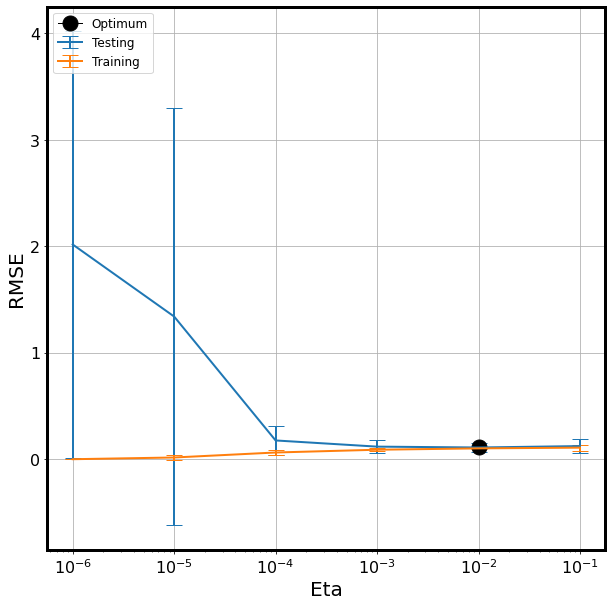

In [4]:
# Options for growth
niter = 1
mindex_growth = None

# Determine order of the starting basis
if mindex_growth == None:
    start_ord = nord # if no basis growth, order of the final basis = order of the starting basis
else:
    start_ord = nord-niter+1 # if basis growth, shrink starting basis to allow for growth niter-1 times
    
# Define PC object
pc_start = uqtkpce.PCSet("NISPnoq", start_ord, ndim, pc_type, pc_alpha, pc_beta)

# Determine coefficients through BCS
pc_final, c_k = pce_tools.UQTkBCS(pc_start, x_train, y_train, niter, eta, ntry, eta_folds, mindex_growth, regparams, sigma, trval_frac, npccut, pcf_thr, verbose, eta_plot)

# Evaluate the PCE
pce_evals = pce_tools.UQTkEvaluatePCE(pc_final, c_k, x_test)

# Calculate error metric
MSE = np.square(np.subtract(y_test, pce_evals)).mean()
NRMSE=math.sqrt(MSE)/np.abs(y_test.mean())
print("The NRMS error between a", ndim, "-dimensional", model, "function and a BCS-based PC surrogate of \
order", nord, "is")
NRMSE

#### 1 Iteration of Nonconservative Growth

Optimal eta is 0.01
============  Split # 1 / 3 ============
==== BCS with multiindex of size 70 ====
BCS has selected 5 basis terms out of 70
============  Split # 2 / 3 ============
==== BCS with multiindex of size 5 ====
BCS has selected 5 basis terms out of 5
============  Split # 3 / 3 ============
==== BCS with multiindex of size 5 ====
BCS has selected 5 basis terms out of 5
Coefficients:
[-0.35614964 -0.30447082 -0.13004623 -0.24340409 -0.39351898]
5  terms retained out of a full basis of size 70
The NRMS error between a 4 -dimensional genz_osc function and a BCS-based PC surrogate of order 4 is


1.1882152922859561

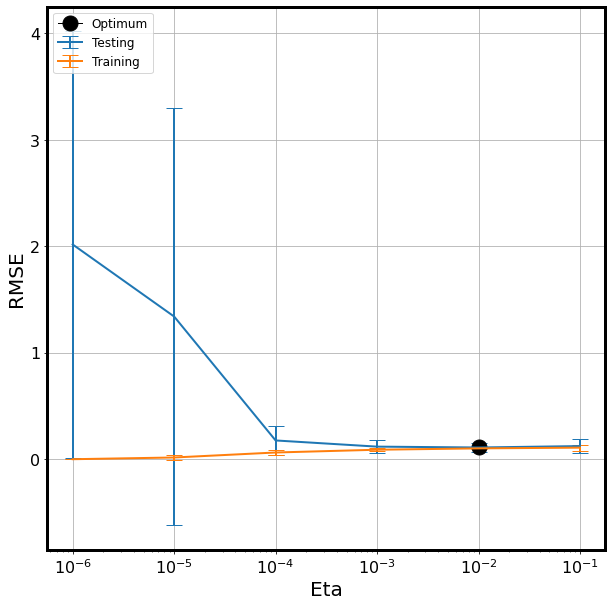

In [5]:
# Options for growth
niter=1                       
mindex_growth =  'nonconservative'

# Determine order of the starting basis
if mindex_growth == None:
    start_ord = nord # if no basis growth, order of the final basis = order of the starting basis
else:
    start_ord = nord-niter+1 # if basis growth, shrink starting basis to allow for growth niter-1 times

# Define PC object    
pc_start = uqtkpce.PCSet("NISPnoq", start_ord, ndim, pc_type, pc_alpha, pc_beta)

# Determine coefficients through BCS
pc_final, c_k = pce_tools.UQTkBCS(pc_start, x_train, y_train, niter, eta, ntry, eta_folds, mindex_growth, regparams, sigma, trval_frac, npccut, pcf_thr, verbose, eta_plot)

# Evaluate the PCE
pce_evals = pce_tools.UQTkEvaluatePCE(pc_final, c_k, x_test)

# Calculate error metric
MSE = np.square(np.subtract(y_test, pce_evals)).mean()
NRMSE=math.sqrt(MSE)/np.abs(y_test.mean())
print("The NRMS error between a", ndim, "-dimensional", model, "function and a BCS-based PC surrogate of \
order", nord, "is")
NRMSE

#### 2 Iterations of Nonconservative Growth

Optimal eta is 0.001
============  Split # 1 / 3 ============
==== BCS with multiindex of size 35 ====
BCS has selected 16 basis terms out of 35
==== BCS with multiindex of size 53 ====
BCS has selected 14 basis terms out of 53
============  Split # 2 / 3 ============
==== BCS with multiindex of size 14 ====
BCS has selected 14 basis terms out of 14
==== BCS with multiindex of size 51 ====
BCS has selected 11 basis terms out of 51
============  Split # 3 / 3 ============
==== BCS with multiindex of size 11 ====
BCS has selected 9 basis terms out of 11
==== BCS with multiindex of size 34 ====
BCS has selected 7 basis terms out of 34
Coefficients:
[-0.36159581 -0.4003449  -0.42695139 -0.36334667 -0.42364005]
5  terms retained out of a full basis of size 70
The NRMS error between a 4 -dimensional genz_osc function and a BCS-based PC surrogate of order 4 is


0.3662391313936097

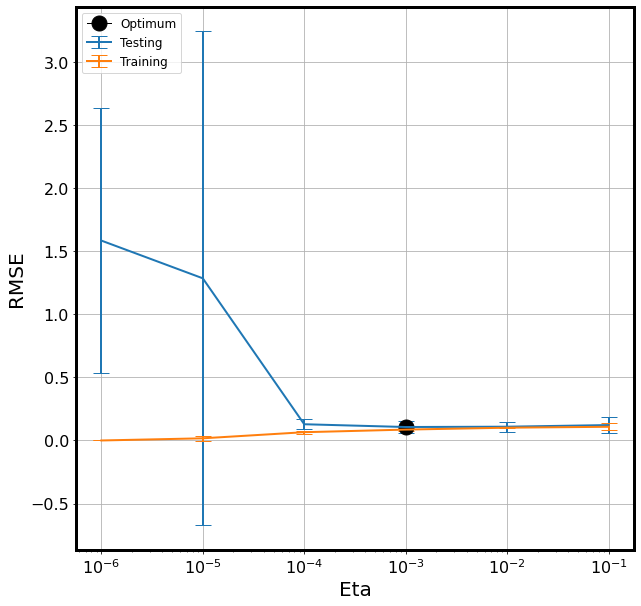

In [6]:
# Options for growth
niter = 2

# Determine order of the starting basis
if mindex_growth == None:
    start_ord = nord # if no basis growth, order of the final basis = order of the starting basis
else:
    start_ord = nord-niter+1 # if basis growth, shrink starting basis to allow for growth niter-1 times

# Define PC Object 
pc_start = uqtkpce.PCSet("NISPnoq", start_ord, ndim, pc_type, pc_alpha, pc_beta)

# Determine coefficients through BCS
pc_final, c_k = pce_tools.UQTkBCS(pc_start, x_train, y_train, niter, eta, ntry, eta_folds, mindex_growth, regparams, sigma, trval_frac, npccut, pcf_thr, verbose, eta_plot)

# Evaluate the PCE
pce_evals = pce_tools.UQTkEvaluatePCE(pc_final, c_k, x_test)

# Calculate error metric
MSE = np.square(np.subtract(y_test, pce_evals)).mean()
NRMSE=math.sqrt(MSE)/np.abs(y_test.mean())
print("The NRMS error between a", ndim, "-dimensional", model, "function and a BCS-based PC surrogate of \
order", nord, "is")
NRMSE

#### 3 Iterations of Nonconservative Growth

Optimal eta is 0.01
============  Split # 1 / 3 ============
==== BCS with multiindex of size 15 ====
BCS has selected 6 basis terms out of 15
==== BCS with multiindex of size 19 ====
BCS has selected 6 basis terms out of 19
==== BCS with multiindex of size 19 ====
BCS has selected 6 basis terms out of 19
============  Split # 2 / 3 ============
==== BCS with multiindex of size 6 ====
BCS has selected 6 basis terms out of 6
==== BCS with multiindex of size 19 ====
BCS has selected 6 basis terms out of 19
==== BCS with multiindex of size 20 ====
BCS has selected 6 basis terms out of 20
============  Split # 3 / 3 ============
==== BCS with multiindex of size 6 ====
BCS has selected 6 basis terms out of 6
==== BCS with multiindex of size 20 ====
BCS has selected 6 basis terms out of 20
==== BCS with multiindex of size 19 ====
BCS has selected 9 basis terms out of 19
Coefficients:
[-0.36159581 -0.4003449  -0.42695139 -0.36334667 -0.42364005]
5  terms retained out of a full basis of size 7

0.3662391313936097

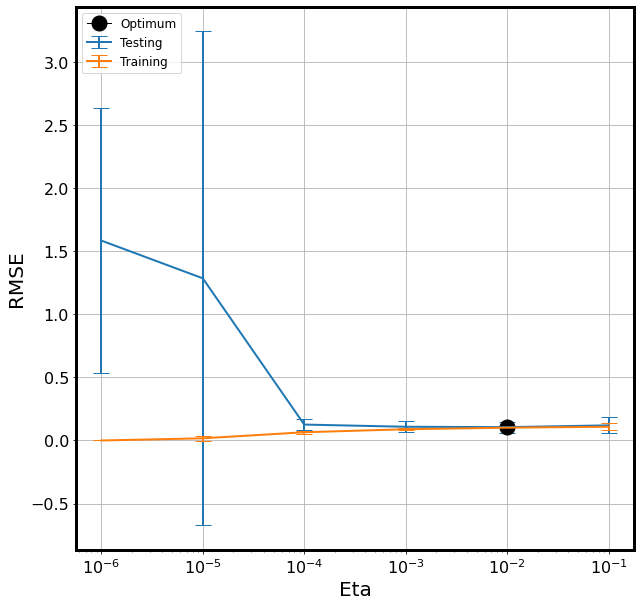

In [7]:
# Options for growth
niter=3

# Determine order of the starting basis
if mindex_growth == None:
    start_ord = nord # if no basis growth, order of the final basis = order of the starting basis
else:
    start_ord = nord-niter+1 # if basis growth, shrink starting basis to allow for growth niter-1 times

# Define PC object
pc_start = uqtkpce.PCSet("NISPnoq", start_ord, ndim, pc_type, pc_alpha, pc_beta)

# Determine coefficients through BCS
pc_final, c_k = pce_tools.UQTkBCS(pc_start, x_train, y_train, niter, eta, ntry, eta_folds, mindex_growth, regparams, sigma, trval_frac, npccut, pcf_thr, verbose, eta_plot)

# Evaluate the PCE
pce_evals = pce_tools.UQTkEvaluatePCE(pc_final, c_k, x_test)

# Calculate error metric
MSE = np.square(np.subtract(y_test, pce_evals)).mean()
NRMSE=math.sqrt(MSE)/np.abs(y_test.mean())
print("The NRMS error between a", ndim, "-dimensional", model, "function and a BCS-based PC surrogate of \
order", nord, "is")
NRMSE